In [285]:
from pymongo import MongoClient
import pprint

import pandas as pd
import matplotlib.pyplot as plt

import requests

from bs4 import BeautifulSoup

import json
import datetime
import calendar
import time
import numpy as np
import scipy.stats as stats

In [42]:
#  Connect to the hosted MongoDB instance
client = MongoClient()

In [43]:
# Access already existing database
db = client['capstone1_bball_reference']

In [44]:
# Access already existing collection in database
all_seasons = db['all_seasons']

In [54]:
actual_links = db.all_seasons.distinct("link")

## Get HTML pages from MongoDB and parse with Beautiful Soup

In [102]:
def parse_to_df(links, starting_season,ending_season):
    
    date = []
    visiting = []
    visiting_score = []
    home = []
    home_score = []
    season = []
    notes = []
    
    for i,link in enumerate(links):
        
        if starting_season <= int(link.split("_")[1]) <= ending_season:
        
            sub_season = all_seasons.find_one({'link':link})['html']
            soup = BeautifulSoup(sub_season,'html.parser')

            for i,game in enumerate(soup.find_all('tr')):
                if game.a != None: #skips the chart label rows
                    datestring = game.find('a').text[5:]
                    dt = datetime.datetime.strptime(datestring,'%b %d, %Y') #change datestring to datetime object
                    date.append(dt)
                    visiting.append(game.find_all('td','left')[0].text)
                    home.append(game.find_all('td','left')[1].text)
                    season.append(soup.find_all('div','inactive')[0].find('li','index').text.rstrip())
                    notes.append(game.find_all('td','left')[-1].text)
                    if len(soup.find_all('col'))==10: #takes care of the different column counts 
                        if (game.find_all('td','right')[1].text) != '': #accommodates for games that were scheduled but never played have have no scores
                            visiting_score.append(int(game.find_all('td','right')[1].text))
                            home_score.append(int(game.find_all('td','right')[2].text))
                        else: 
                            visiting_score.append(0)
                            home_score.append(0)
                    else:
                        if (game.find_all('td','right')[0].text) != '':
                            visiting_score.append(int(game.find_all('td','right')[0].text))
                            home_score.append(int(game.find_all('td','right')[1].text))
                        else: 
                            visiting_score.append(0)
                            home_score.append(0)
                
    df = pd.DataFrame({'date':date,'season':season,'visiting_team':visiting,'visiting_score':visiting_score,
                  'home_team':home, 'home_score':home_score, 'notes':notes})
    return df

In [195]:
df = parse_to_df(actual_links, 2010, 2019)

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12897 entries, 0 to 12896
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            12897 non-null  datetime64[ns]
 1   season          12897 non-null  object        
 2   visiting_team   12897 non-null  object        
 3   visiting_score  12897 non-null  int64         
 4   home_team       12897 non-null  object        
 5   home_score      12897 non-null  int64         
 6   notes           12897 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 705.4+ KB


In [198]:
df.head()

,date,season,visiting_team,visiting_score,home_team,home_score,notes
0,2010-04-01,2009-10 NBA Season,Orlando Magic,97,Dallas Mavericks,82,
1,2010-04-01,2009-10 NBA Season,Portland Trail Blazers,92,Denver Nuggets,109,
2,2010-04-02,2009-10 NBA Season,Milwaukee Bucks,86,Charlotte Bobcats,87,
3,2010-04-02,2009-10 NBA Season,Miami Heat,105,Indiana Pacers,96,
4,2010-04-02,2009-10 NBA Season,Chicago Bulls,95,Washington Wizards,87,


Drop rows with notes (these rows are where games are played elsewhere - not at either teams' arenas) and rows with 0's as scores (these games were scheduled but have not been played)

In [199]:
df[df.notes!='']['notes'].count()

17

In [200]:
df[df.visiting_score == 0]['visiting_score'].count()

7

In [211]:
filtered = df[(df.notes=='') & (df.visiting_score != 0)] # 10 seasons and 12873 played that we are considering
filtered

,date,season,visiting_team,visiting_score,home_team,home_score,notes
0,2010-04-01,2009-10 NBA Season,Orlando Magic,97,Dallas Mavericks,82,
1,2010-04-01,2009-10 NBA Season,Portland Trail Blazers,92,Denver Nuggets,109,
2,2010-04-02,2009-10 NBA Season,Milwaukee Bucks,86,Charlotte Bobcats,87,
3,2010-04-02,2009-10 NBA Season,Miami Heat,105,Indiana Pacers,96,
4,2010-04-02,2009-10 NBA Season,Chicago Bulls,95,Washington Wizards,87,
...,...,...,...,...,...,...,...
12885,2018-10-31,2018-19 NBA Season,Utah Jazz,125,Minnesota Timberwolves,128,
12886,2018-10-31,2018-19 NBA Season,Indiana Pacers,107,New York Knicks,101,
12887,2018-10-31,2018-19 NBA Season,New Orleans Pelicans,121,Golden State Warriors,131,
12888,2018-10-31,2018-19 NBA Season,Dallas Mavericks,113,Los Angeles Lakers,114,


array([[<AxesSubplot:xlabel='visiting_score', ylabel='visiting_score'>,
        <AxesSubplot:xlabel='home_score', ylabel='visiting_score'>],
       [<AxesSubplot:xlabel='visiting_score', ylabel='home_score'>,
        <AxesSubplot:xlabel='home_score', ylabel='home_score'>]],
      dtype=object)

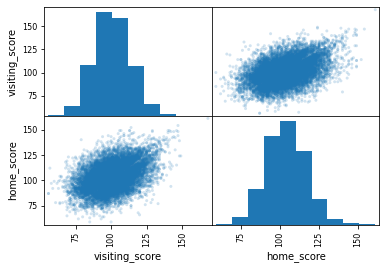

In [213]:
pd.plotting.scatter_matrix(filtered, alpha = 0.2)

At first glance at the histograms it looks like majority of the scores of the visiting teams are just left of 100 points vs. scores of the home teams are just right of 100. They look normally distributed.

## Figure out how many home wins vs visitor wins there are by season and graph it

Approach - create two new columns, home_win and visitor_win, and assign a 1 to the column depending on the winner of the game. This will allow me to do a group by season and sum up the wins per column 

In [214]:
filtered['home_win'] = np.where(filtered['home_score']>filtered['visiting_score'], 1, 0 )

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [218]:
filtered['visitor_win'] = np.where(filtered['visiting_score']>filtered['home_score'], 1, 0 )

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [269]:
filtered

,date,season,visiting_team,visiting_score,home_team,home_score,notes,home_win,visitor_win
0,2010-04-01,2009-10 NBA Season,Orlando Magic,97,Dallas Mavericks,82,,0,1
1,2010-04-01,2009-10 NBA Season,Portland Trail Blazers,92,Denver Nuggets,109,,1,0
2,2010-04-02,2009-10 NBA Season,Milwaukee Bucks,86,Charlotte Bobcats,87,,1,0
3,2010-04-02,2009-10 NBA Season,Miami Heat,105,Indiana Pacers,96,,0,1
4,2010-04-02,2009-10 NBA Season,Chicago Bulls,95,Washington Wizards,87,,0,1
...,...,...,...,...,...,...,...,...,...
12885,2018-10-31,2018-19 NBA Season,Utah Jazz,125,Minnesota Timberwolves,128,,1,0
12886,2018-10-31,2018-19 NBA Season,Indiana Pacers,107,New York Knicks,101,,0,1
12887,2018-10-31,2018-19 NBA Season,New Orleans Pelicans,121,Golden State Warriors,131,,1,0
12888,2018-10-31,2018-19 NBA Season,Dallas Mavericks,113,Los Angeles Lakers,114,,1,0


In [298]:
total_home_wins = filtered[filtered.home_win==1]['home_team'].count()
total_home_wins

7626

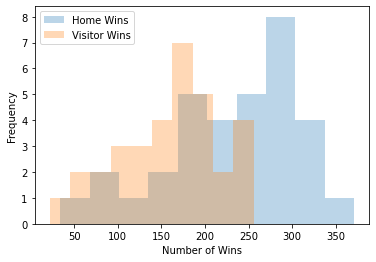

In [260]:
home_wins = filtered.groupby('home_team')[['home_team','home_win']].sum()
visitor_wins = filtered.groupby('visiting_team')[['visiting_team','visitor_win']].sum()
fig, ax = plt.subplots()
ax.hist(home_wins,alpha=0.3,bins=10,label="Home Wins")
ax.hist(visitor_wins,alpha=0.3,bins=10,label="Visitor Wins")
ax.set_xlabel('Number of Wins')
ax.set_ylabel('Frequency')
ax.legend();

## One Sample Test of Population Proportions
* Scientific Question - Is home court advantage real?
* Null Hypothesis: There is no such thing as a home court advantage. p = 0.5
* Alternative Hypothesis: There is such a thing as home court advantage. p > 0.5
* Test statistic: number of games won by home teams (observed = 7626 wins/12874)
* Significance level: 0.05
* Distribution of the null
    * Binomial where n = 12873 games p = 0.5

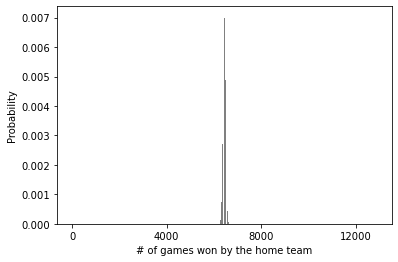

In [304]:
binomial = stats.binom(n=12873, p=0.5)

fig, ax = plt.subplots()
bars = ax.bar(range(12874), [binomial.pmf(i) for i in range(12874)], color="grey")
ax.set_xlabel('# of games won by the home team')
ax.set_ylabel('Probability')
for i in range(total_home_wins,12874):
    bars[i].set_color('red')
ax.set_xticks(np.arange(0,12874,4000));

In [305]:
prob_equal_or_more_extreme = 1 - binomial.cdf(12872) # binomial.cdf(1)
print("Probability of Observing Data More Equal or More Extreme than Actual: {:2.2}".format(
    prob_equal_or_more_extreme))

Probability of Observing Data More Equal or More Extreme than Actual: 1.1e-16
